In [495]:
import numpy as np
import pandas as pd;
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as st
import operator

In [496]:
a1_color = '#664c85'
a2_color = '#5b92b6'
a3_color = '#52d5bd'
a4_color = '#eeeeee'
a1_palette = 'mako'
a2_palette = 'mako_r'

## Houseprices
**Questions**
  * Which among the attributes of properties contribute to the house sales price?
  * What are the characteristics of house that are considered expensive?
  * Which among the variables are correlated against the sales price and as well as against other variables?
  * Are there other hidden variables that may affect sales price upon doing drilling down the data?

### Initialization

In [497]:
df_train = pd.read_csv(r'../../../data/csv/train.csv')

In [498]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [499]:
df_train.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


#### Missing values

In [500]:
df_train_missingval = (
    pd.DataFrame(
        df_train.isnull().sum()[df_train.isnull().sum() > 0]
    )
    .reset_index()
    .rename(columns = {0 : 'missing_values_count', 'index' : 'column_name'})
    .sort_values(by='missing_values_count')
)

df_train_missingval = df_train_missingval.assign(missing_count_relative = df_train_missingval['missing_values_count'] / len(df_train.columns))
df_train_missingval

,column_name,missing_values_count,missing_count_relative
9,Electrical,1,0.012346
2,MasVnrType,8,0.098765
3,MasVnrArea,8,0.098765
4,BsmtQual,37,0.456790
5,BsmtCond,37,0.456790
7,BsmtFinType1,37,0.456790
6,BsmtExposure,38,0.469136
8,BsmtFinType2,38,0.469136
15,GarageCond,81,1.000000
14,GarageQual,81,1.000000


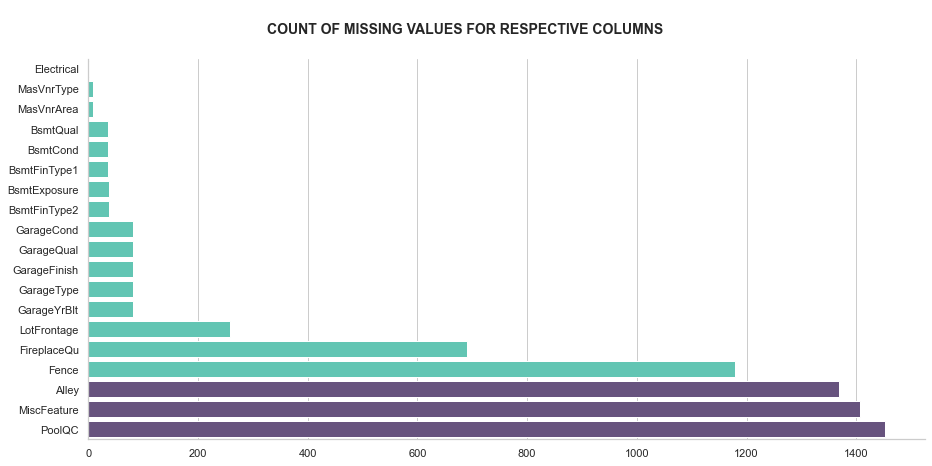

In [501]:
sns.set(
    rc = {'figure.figsize' : (15,7)},
    style = 'whitegrid'
)

g = sns.barplot(
    data = df_train_missingval,
    y = 'column_name',
    x = 'missing_values_count',
    palette = [a1_color if x == True else a3_color for x in df_train_missingval['missing_values_count'].isin(df_train_missingval['missing_values_count'].nlargest(1+2))],
)

g.set_xlabel('')
g.set_ylabel('')
g.set_title(
    '\nCount of missing values for respective columns'.upper(),
    fontdict = dict(
        fontsize = 14,
        fontweight = 'bold'
    ),
    y = 1.05,
    x = .45
)

sns.despine()

#### Dataframe remap

In [502]:
# for columns in df_train[categorical_columns_df_train]:
#     df_train[columns] = df_train[columns].astype('category')

# df_train[categorical_columns_df_train].astype('category').isnull().any()

df_train['Alley'].astype('category').cat.add_categories(['MISSING']).fillna('MISSING').value_counts()


MISSING    1369
Grvl         50
Pave         41
Name: Alley, dtype: int64

In [503]:
# Remap dataframe
df_train = df_train.loc[:, df_train.columns.isin(['MSZoning','Street', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'YearBuilt', 'YearRemodAdd', 'CentralAir', 'Heating', 'Foundation', 'Electrical', 'YrSold', 'SaleCondition', 'SalePrice'])]

# Rearrange columns
df_train = df_train[[
    'HouseStyle',
    'RoofStyle',
    'Exterior1st',
    'Exterior2nd',
    'Foundation',
    'Electrical',
    'Heating',
    'CentralAir',
    'Street',
    'MSZoning',
    'YearBuilt',
    'YearRemodAdd',
    'YrSold',
    'SaleCondition',
    'SalePrice'
]]

df_train

,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,Foundation,Electrical,Heating,CentralAir,Street,MSZoning,YearBuilt,YearRemodAdd,YrSold,SaleCondition,SalePrice
0,2Story,Gable,VinylSd,VinylSd,PConc,SBrkr,GasA,Y,Pave,RL,2003,2003,2008,Normal,208500
1,1Story,Gable,MetalSd,MetalSd,CBlock,SBrkr,GasA,Y,Pave,RL,1976,1976,2007,Normal,181500
2,2Story,Gable,VinylSd,VinylSd,PConc,SBrkr,GasA,Y,Pave,RL,2001,2002,2008,Normal,223500
3,2Story,Gable,Wd Sdng,Wd Shng,BrkTil,SBrkr,GasA,Y,Pave,RL,1915,1970,2006,Abnorml,140000
4,2Story,Gable,VinylSd,VinylSd,PConc,SBrkr,GasA,Y,Pave,RL,2000,2000,2008,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2Story,Gable,VinylSd,VinylSd,PConc,SBrkr,GasA,Y,Pave,RL,1999,2000,2007,Normal,175000
1456,1Story,Gable,Plywood,Plywood,CBlock,SBrkr,GasA,Y,Pave,RL,1978,1988,2010,Normal,210000
1457,2Story,Gable,CemntBd,CmentBd,Stone,SBrkr,GasA,Y,Pave,RL,1941,2006,2010,Normal,266500
1458,1Story,Hip,MetalSd,MetalSd,CBlock,FuseA,GasA,Y,Pave,RL,1950,1996,2010,Normal,142125


In [504]:
# Getting numerical and categorical columns
numerical_columns_df_train = df_train.select_dtypes(include = np.number).columns.tolist()
categorical_columns_df_train = df_train.columns[~df_train.columns.isin(numerical_columns_df_train)].tolist()

In [505]:
# Labeling missing data
for column in df_train[categorical_columns_df_train]:
    df_train[column] = (df_train[column].astype('category'))
    if df_train[column].isnull().any():
        df_train[column] = (
            df_train[column]
            .cat
            .add_categories(['MISSING'])
            .fillna('MISSING')
        )

df_train[categorical_columns_df_train].isna().any()

HouseStyle       False
RoofStyle        False
Exterior1st      False
Exterior2nd      False
Foundation       False
Electrical       False
Heating          False
CentralAir       False
Street           False
MSZoning         False
SaleCondition    False
dtype: bool

### Analysis

#### Frequency distribution of the sales price

In [506]:
# Skew interpretation
def get_skew_remarks(var_skew):
    if var_skew > 1:
        return "highly positively skewed"
    elif var_skew <- 1:
        return "highly negatively skewed"
    elif (var_skew <= 1 and var_skew >= 0.5):
        return "postively moderately skewed"
    elif (var_skew >= -1 and var_skew <= -0.5):
        return "moderately negatively skewed"
    elif (var_skew < 0.5 and var_skew > -0.5):
        return "approximately symmetric"
    else:
        return ""

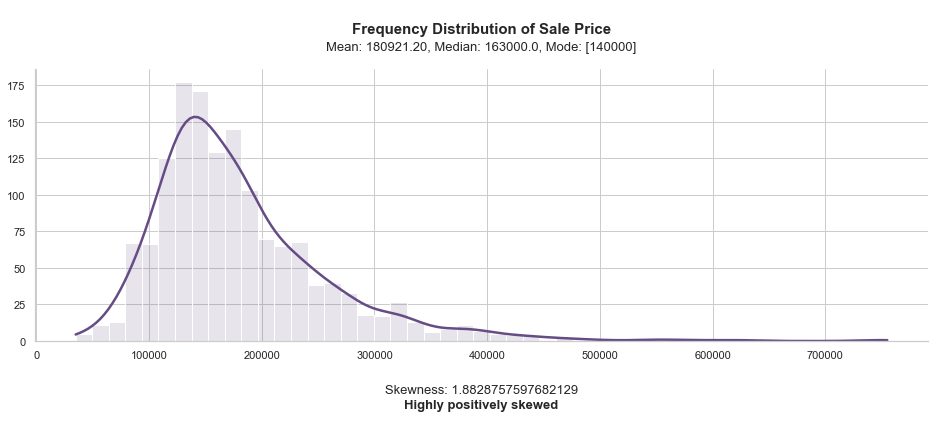

In [507]:
var_mean_saleprice_df_train = df_train['SalePrice'].mean()
var_median_saleprice_df_train = df_train['SalePrice'].median()
var_mode_saleprice_df_train = [x for x in df_train['SalePrice'].mode()]
var_skew_saleprice_df_train = df_train['SalePrice'].skew()
var_skew_remarks_df_train = get_skew_remarks(df_train['SalePrice'].skew()).capitalize()

sns.set(
    style = 'whitegrid',
    rc = {'figure.figsize' : (16,5)}
)

g = sns.histplot(
    data = df_train,
    x='SalePrice',
    kde = True,
    color = a1_color,
    alpha = 0.15,
    line_kws = dict(
        lw = 2.5
    )
)

g.set_ylabel('')
g.set_xlabel('')
g.set_title(
    f'\nFrequency Distribution of Sale Price\n',
    horizontalalignment = 'center',
    fontdict = dict(
        fontsize = 15,
        fontweight = 'bold'
    ),
    y = 1.05
)

plt.text(
    s = f'Mean: {var_mean_saleprice_df_train:.2f}, Median: {var_median_saleprice_df_train}, Mode: {var_mode_saleprice_df_train}',
    x = 0.5,
    y = 1.08,
    horizontalalignment = 'center',
    verticalalignment = 'center',
    transform = g.transAxes,
    fontdict = dict(
        fontsize = 13,
        # fontweight = 'bold'
    )
)

plt.text(
    s = f'Skewness: {var_skew_saleprice_df_train}',
    x = 0.5,
    y = -.18,
    horizontalalignment = 'center',
    verticalalignment = 'center',
    transform = g.transAxes,
    fontdict = dict(
        fontsize = 13,
        # fontweight = 'bold'
    )
)

plt.text(
    s = f'{var_skew_remarks_df_train}\n',
    x = 0.5,
    y = -.26,
    horizontalalignment = 'center',
    verticalalignment = 'center',
    transform = g.transAxes,
    fontdict = dict(
        fontsize = 13,
        fontweight = 'bold'
    )
)
sns.despine()


##### Box and whiskers visualizations with var [x] as opposed to saleprice

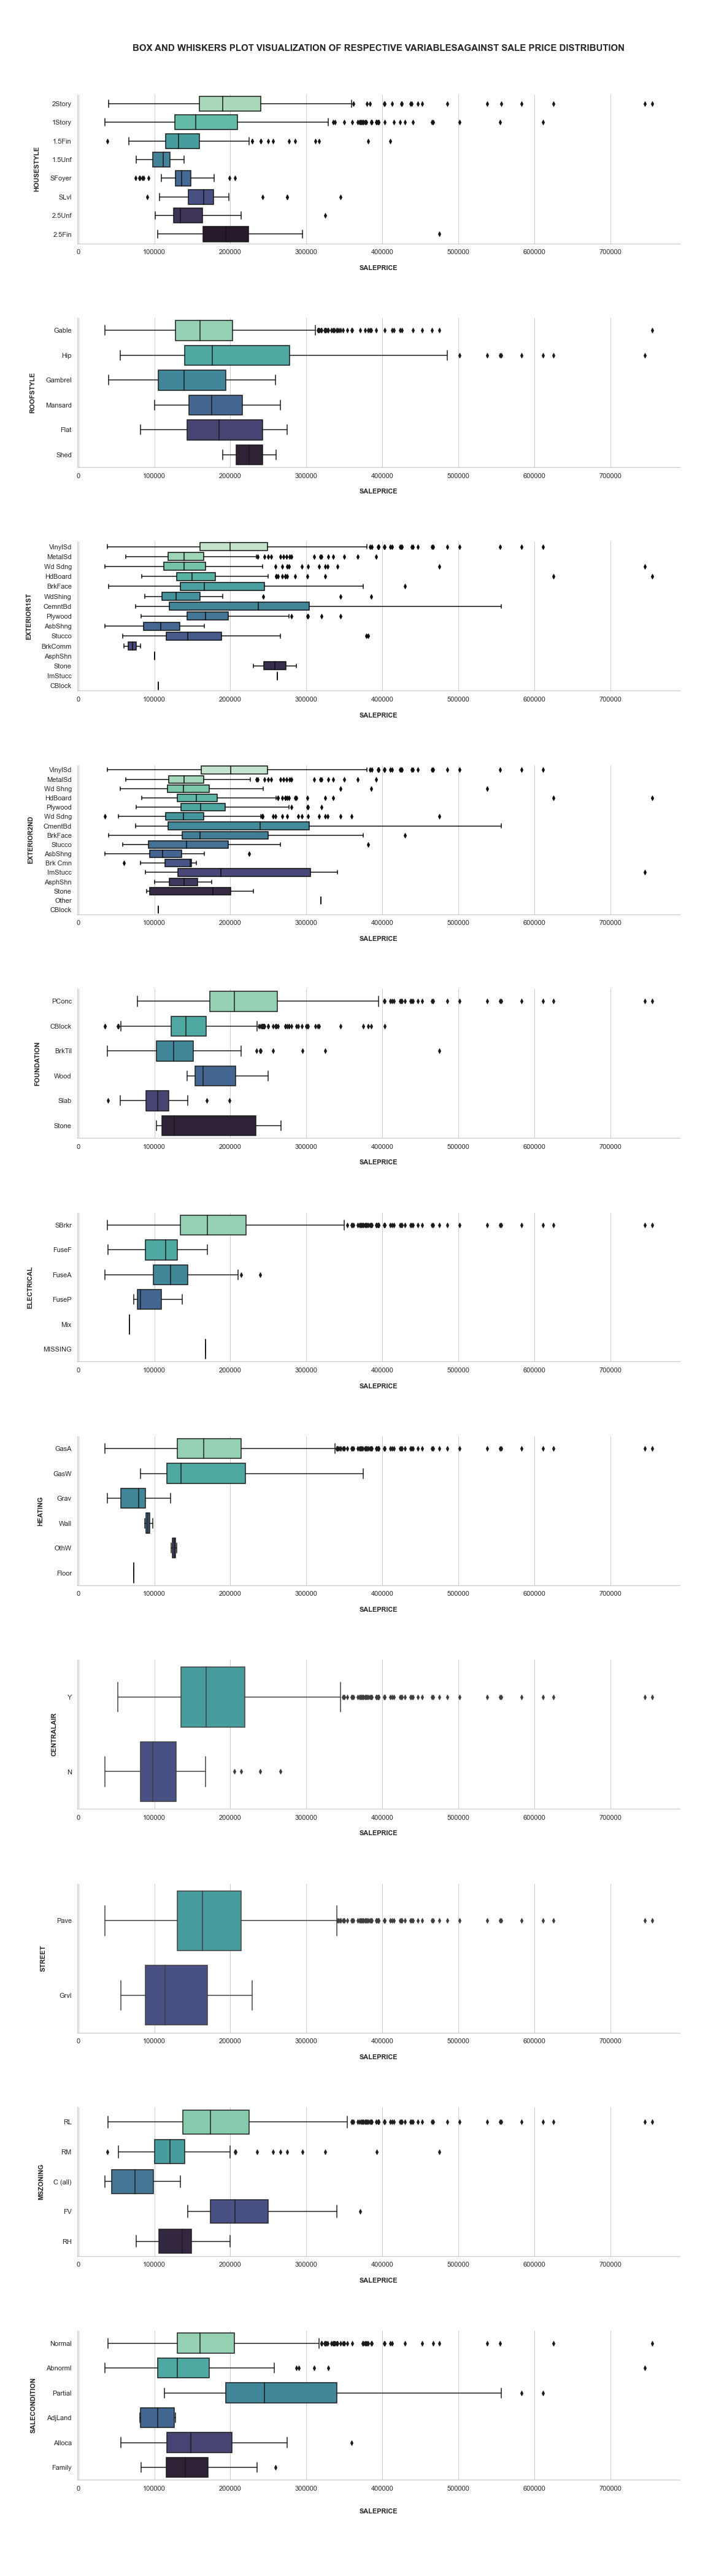

In [508]:
sns.set(style = 'whitegrid')

g = sns.FacetGrid(
    data = pd.melt(df_train, id_vars=['SalePrice'], value_vars = categorical_columns_df_train, value_name = 'element'),
    col = 'variable',
    col_wrap = 1,
    sharex = False,
    sharey = False,
    height = 5,
    aspect = 3,
)
g.map_dataframe(
    func = sns.boxplot,
    x = 'SalePrice',
    y = 'element',
    palette = a2_palette,
)

g.set_titles(col_template='variable = {col_name}')

for axes in g.axes:
    plt.text(
        s = ' ',
        x = 1.05,
        y = 1,
        transform = g.axes[len(g.axes)//2].transAxes,
    )
    axes.set_ylabel(
        f"\n\n\n{axes.get_title()[axes.get_title().find('= ')+2:].upper()}\n",
        fontdict = dict(
            fontsize = 11,
            fontweight = 'bold'
        )
    )
    axes.set_xlabel(
        f'\n{g.axes[-1].get_xlabel().upper()}\n\n\n',
        fontdict = dict(
            fontsize = 11,
            fontweight = 'bold'
        )
    )
    axes.set_title(' ')
    if axes == g.axes[-1]:
        axes.set_xlabel(f'\n{g.axes[-1].get_xlabel().upper()}\n\n\n\n\n')

g.axes[0].set_title(
    '\n\n\n\nBox and whiskers plot visualization of respective variablesagainst sale price distribution\n\n\n\n'.upper(),
    fontdict = dict(
        fontsize = 15,
        fontweight = 'bold'
    )
)

plt.subplots_adjust(
    hspace = 0.5,
    wspace = 0.5
)


#### Variables that are correlated to saleprice and against other variables

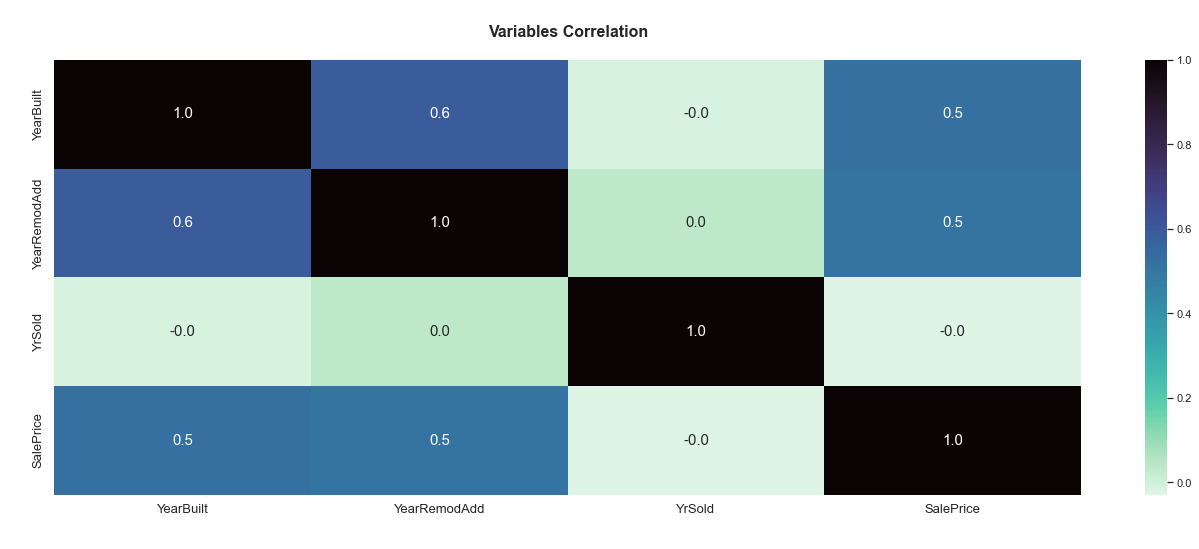

In [509]:
sns.set(
    rc = {'figure.figsize' : (23,8)}
)

g = sns.heatmap(
    data = df_train.corr(),
    annot = True,
    fmt = '.1f',
    annot_kws = dict(
        fontsize = 15
    ),
    cmap = a2_palette,
    cbar_kws = dict(
        orientation = 'vertical',
    )
)

g.set_ylabel(' \n')
g.set_xlabel(' \n')
g.set_title(
    '\nVariables Correlation\n',
    fontdict = dict(
        fontsize = 16,
        fontweight = 'bold'
    )
),

g.set_xticklabels(
    labels = g.get_xticklabels(),
    fontdict = dict(
        fontsize = 13
    )
),
g.set_yticklabels(
    labels = g.get_yticklabels(),
    fontdict = dict(
        fontsize = 13
    )
);

##### Correlation of sales price against numerical variables using regeression analysis

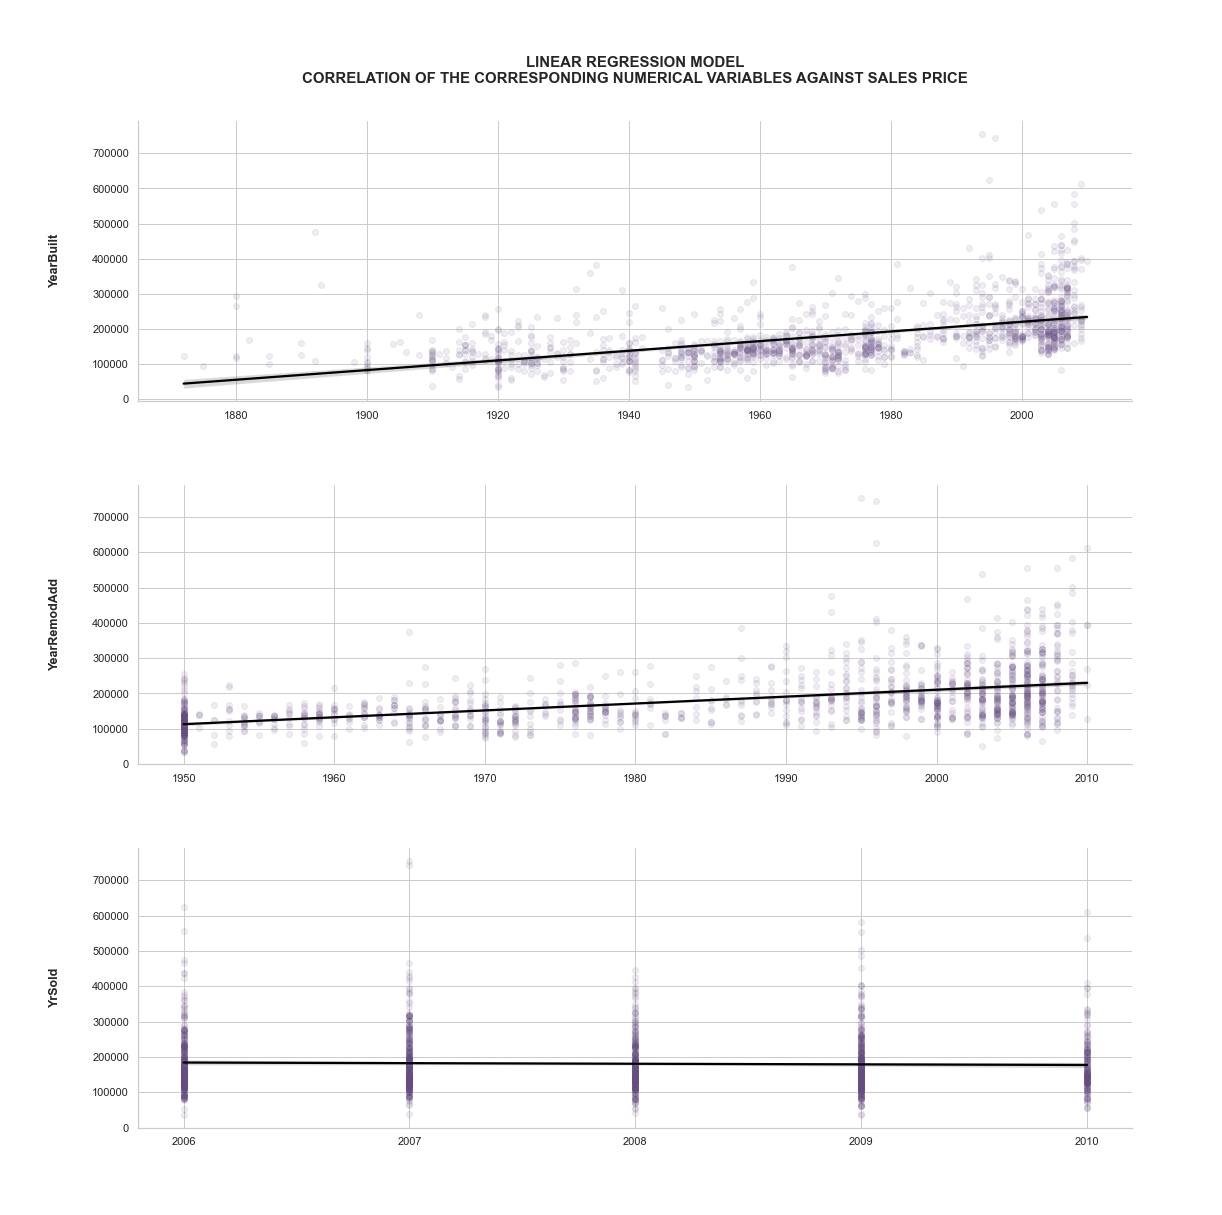

In [516]:
sns.set(
    style = 'whitegrid'
)

g = sns.FacetGrid(
    data = pd.melt(
        frame = df_train,
        id_vars = ['SalePrice'],
        value_vars = numerical_columns_df_train,
        value_name = 'element'
    ),
    col = 'variable',
    col_wrap = 1,
    sharex = False,
    sharey = False,
    height = 5,
    aspect = 3
)

g.map_dataframe(
    func = sns.regplot,
    x = 'element',
    y = 'SalePrice',
    color = a1_color,
    scatter_kws = dict(
        alpha = 0.1
    ),
    line_kws = dict(
        color = '#000000'
    )
)

g.axes[2].set_xticks(df_train['YrSold'].sort_values().unique());

g.set_titles(col_template = '{col_name}')

for axes in g.axes:
    axes.set_ylabel(
        f"\n\n\n{axes.get_title()}\n\n",
        fontdict = dict(
            fontsize = 12.5,
            fontweight = 'bold'
        )
    )
    axes.set_title('')
    axes.set_xlabel('')
    if axes == g.axes[0]:
        axes.set_title(
            "\n\n\nLinear Regression Model\nCorrelation Of The Corresponding Numerical Variables Against Sales Price\n\n".upper(),
            fontdict = dict(
                fontsize = 15,
                fontweight = 'bold'
            )
        )
    elif axes == g.axes[-1]:
        axes.set_xlabel(' \n\n\n\n')

plt.text(
    s = ' ',
    x = 1.08,
    y = 1,
    transform = g.axes[len(g.axes)//2].transAxes
)

plt.subplots_adjust(hspace = 0.3)

##### Correlation of sales price against categorical variables using analysis of variance

In [511]:
def generate_df_grouped_annova(df, column_list):
    p_values = []
    for col in column_list:
        elements_val = []
        for element in df[col].unique():
            elements_val.append(df.groupby(col).get_group(element)['SalePrice'].values)
        p_values.append(st.f_oneway(*elements_val)[1])

    df_annova_grouped = pd.DataFrame(dict(
        feature = column_list,
        p_values = p_values,
        disparity = [np.log(1/x) for x in p_values]
    ))

    return df_annova_grouped.sort_values('p_values')

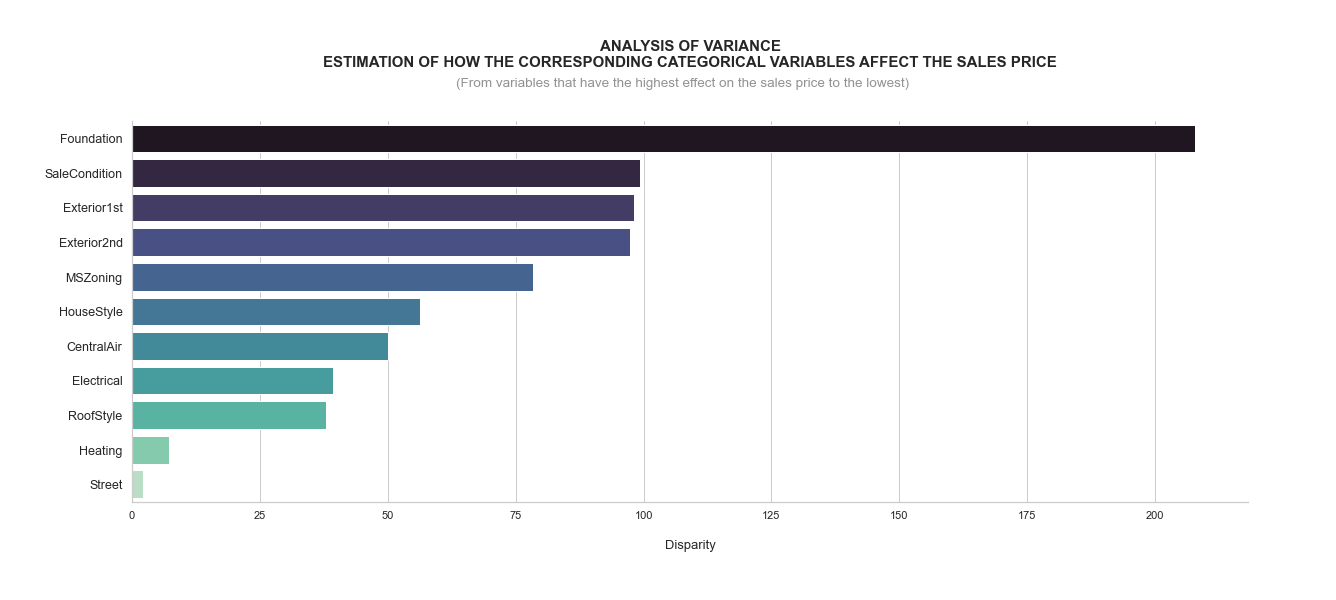

In [512]:
annova_df_train = generate_df_grouped_annova(df_train, categorical_columns_df_train)

sns.set(
    rc = {'figure.figsize' : (20,7)},
    style = 'whitegrid'
)

g = sns.barplot(
    data = annova_df_train, 
    x = 'disparity', 
    y = 'feature',
    palette = a1_palette
)

g.set_ylabel(' \n\n')
g.set_xlabel(
    f"\n{g.get_xlabel().capitalize()}\n\n\n",
    fontdict = dict(
        fontsize = 13,
        fontweight = 'medium'
    )
)
g.set_yticklabels(
    labels = g.get_yticklabels(),
    fontdict = dict(
        fontsize = 12.5,
        fontweight = 'medium'
    )
)
g.set_title(
    '\n\nAnalysis of Variance\nEstimation of how the corresponding categorical variables affect the sales price\n\n\n'.upper(),
    fontdict = dict(
        fontsize = 15,
        fontweight = 'bold'
    ),
)
plt.text(
    s = '(From variables that have the highest effect on the sales price to the lowest)',
    x = 0.29,
    y = 1.09,
    transform = g.transAxes,
    fontdict = dict(
        fontsize = 13.5,
        alpha = 0.5
    )
)
plt.text(
    s = ' ',
    x = 1.07,
    y = 1,
    transform = g.transAxes
)


sns.despine()

##### Correlation of sales price against all variables

In [513]:
def generate_df_grouped_spearman(dataframe, features, col_to_corr):
    df_spearman_grouped = pd.DataFrame(dict(
        features = features,
        spearman = [dataframe[feature].corr(dataframe[col_to_corr], method = 'spearman') for feature in features]
    ))

    return df_spearman_grouped.sort_values('spearman')

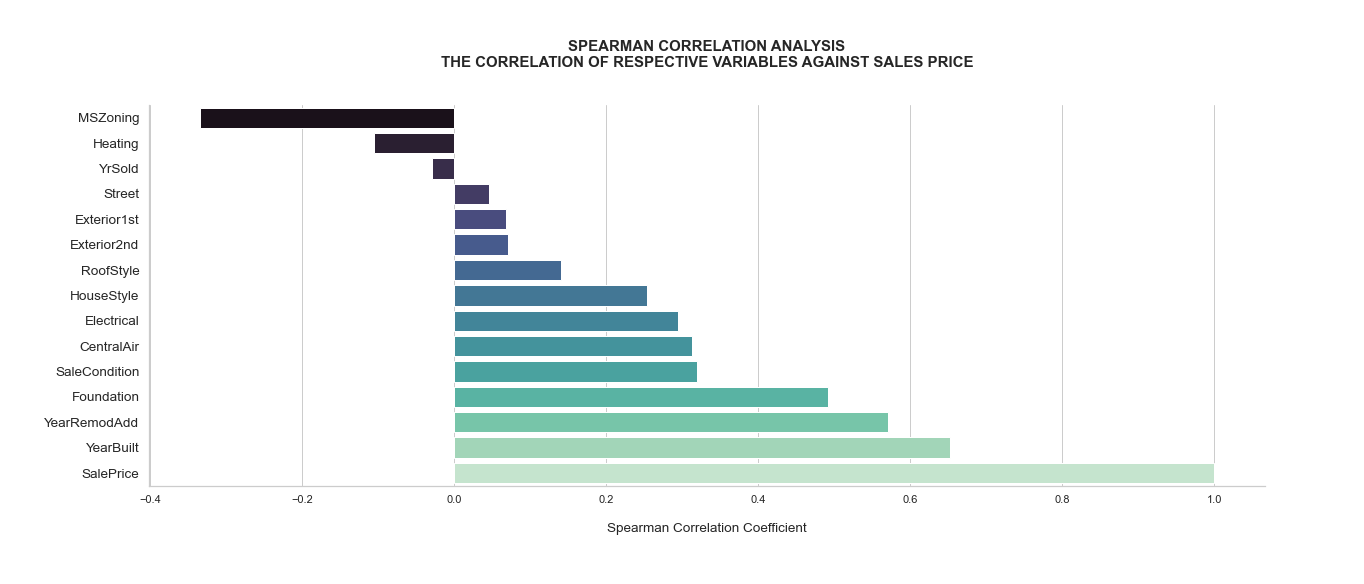

In [514]:
df_spearman_grouped = generate_df_grouped_spearman(
    dataframe = df_train,
    features = numerical_columns_df_train + categorical_columns_df_train,
    col_to_corr = 'SalePrice'
)

g = sns.barplot(
    data = df_spearman_grouped,
    y = 'features',
    x = 'spearman',
    palette = a1_palette
)

g.set_ylabel(' \n\n')

g.set_xlabel(
    f"\n{g.get_xlabel().capitalize()} Correlation Coefficient\n\n\n",
    fontdict = dict(
        fontsize = 13.5,
        fontweight = 'medium',
    )
)

g.set_yticklabels(
    labels = g.get_yticklabels(),
    fontdict = dict(
        fontsize = 13.5,
        fontweight = 'medium'
    )
)

g.set_title(
    f"\n\nSpearman Correlation Analysis\nThe correlation of respective variables against sales price\n\n".upper(),
    fontdict = dict(
        fontsize = 15,
        fontweight = 'bold',
    )
)

plt.text(
    s = ' ',
    transform = g.transAxes,
    x = 1.08,
    y = 1,
)

sns.despine()